#### Includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import altair as alt
from altair import datum
import pandas as pd

import sys

In [10]:
sys.path.insert(0, '../../')
from lib.utils.rotequivariance_toolbox import *
from lib.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from lib.steered_conv import SteerableKernelBase
from lib.models import SteeredHemelingNet, HemelingNet
from experiments.trainer import BinaryClassifierNet
from experiments import load_dataset, parse_config, setup_model

## Spatial Homogeneity

In [129]:
base = SteerableKernelBase.create_from_rk(4, max_k=5)

x = torch.linspace(-1, 1, 3)
x,y = torch.meshgrid(x,x)
d = torch.sqrt(x**2+y**2)
std = 1
G = torch.exp(-d**2/(2*std**2))
G /= G.sum()

k = 7
x = torch.linspace(-k/2, k/2, k)
x,y = torch.meshgrid(x,x)
d = torch.maximum(torch.sqrt(x**2+y**2)-k//2, torch.Tensor([0]))
window =  torch.exp(-torch.square(d)*2)


K = torch.randn((2000,1,k,k)) 
K = torch.conv2d(K, G[None, None], padding=1)
K = K * window

W = base.approximate_weights(K)


tensor(-23477438586612238835343425536.)

In [130]:
w_df = pd.DataFrame(data=base.weights_dist(W, Q=5))
w_df

,r,k,type,name,median,q0,-q0,q1,-q1,q2,-q2,q3,-q3,q4,-q4
0,0,0,R,"r=0, k=0, Real",-5.016802e+07,1.766355e+10,-3.093652e+10,5.098646e+09,-9.184783e+09,1.424289e+09,-2.784777e+09,2.422578e+08,-6.391274e+08,-5.016802e+07,-5.016802e+07
1,1,0,R,"r=1, k=0, Real",-2.436909e+11,3.290170e+20,-3.763133e+20,9.249088e+18,-2.344801e+19,1.850591e+16,-3.298614e+17,1.476203e+13,-2.137355e+14,-2.436909e+11,-2.436909e+11
2,2,0,R,"r=2, k=0, Real",-8.650966e+11,5.975942e+20,-8.352496e+20,1.808592e+19,-2.938807e+19,3.885065e+16,-1.144807e+17,1.353192e+14,-2.460201e+14,-8.650966e+11,-8.650966e+11
3,3,0,R,"r=3, k=0, Real",-5.691743e+12,6.676330e+20,-7.888930e+20,5.971559e+18,-3.316234e+19,2.190331e+16,-2.564763e+17,1.046891e+14,-9.540865e+14,-5.691743e+12,-5.691743e+12
4,1,1,R,"r=1, k=1, Real",5.926516e+11,6.067734e+20,-9.942645e+20,1.435518e+19,-2.581285e+19,6.687284e+16,-1.334379e+17,5.032323e+14,-6.445783e+14,5.926516e+11,5.926516e+11
5,1,1,I,"r=1, k=1, Imag",-4.027278e+12,5.003941e+20,-8.336486e+20,1.366228e+19,-3.431587e+19,8.484675e+16,-1.349034e+17,4.356393e+14,-7.354123e+14,-4.027278e+12,-4.027278e+12
6,2,1,R,"r=2, k=1, Real",-1.762561e+12,3.563107e+20,-9.880962e+20,6.665290e+18,-1.631304e+19,4.158904e+16,-6.879791e+16,4.441167e+14,-7.784291e+14,-1.762561e+12,-1.762561e+12
7,2,1,I,"r=2, k=1, Imag",-3.850992e+11,6.140546e+20,-8.333208e+20,1.248473e+19,-2.201686e+19,3.079162e+16,-8.236639e+16,2.926747e+14,-3.237960e+14,-3.850992e+11,-3.850992e+11
8,3,1,R,"r=3, k=1, Real",-9.520297e+11,1.452353e+21,-9.372184e+20,6.853843e+19,-2.058165e+19,2.527677e+17,-3.621368e+16,4.888854e+14,-3.577881e+14,-9.520297e+11,-9.520297e+11
9,3,1,I,"r=3, k=1, Imag",2.204901e+12,8.363857e+20,-4.234492e+20,2.013712e+19,-9.174903e+18,9.123483e+16,-1.486816e+16,1.216536e+14,-2.447750e+13,2.204901e+12,2.204901e+12


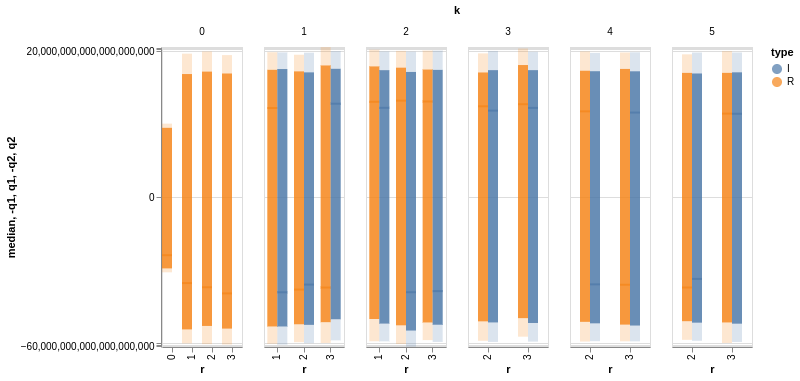

In [131]:
chart = alt.Chart(w_df)
layered = alt.LayerChart()
for real in [True, False]:
    layered += chart.mark_tick(
                        thickness=2,
                        width=10,
                        xOffset=-5 if real else 5
                    ).encode(
                        alt.X('r:N'), alt.Y('median:Q', scale=alt.Scale(type='symlog')), 
                        alt.Color('type:N')
                    ).transform_filter(datum.type== ('R' if real else 'I') )
    layered += chart.mark_bar(
                        opacity=.2, 
                        width=10, 
                        xOffset=-5 if real else 5
                 ).encode(
                    alt.X('r:N'), alt.Y('-q1:Q'), alt.Y2('q1:Q'), 
                    alt.Color('type:N')
                  ).properties(width=80).transform_filter(datum.type== ('R' if real else 'I') )
    layered += chart.mark_bar(
                        opacity=.8, 
                        width=10, 
                        xOffset=-5 if real else 5
                 ).encode(
                    alt.X('r:N'), alt.Y('-q2:Q'), alt.Y2('q2:Q'), 
                    alt.Color('type:N')
                  ).properties(width=80).transform_filter(datum.type== ('R' if real else 'I') )
layered.facet('k:O').resolve_scale(x='independent').interactive()

/home/gaby/.conda/envs/nnet/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


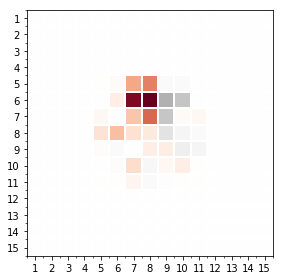

In [75]:
h, w = 15, 15
I = torch.zeros((1,1,h,w))
I[0,0,h//2,w//2] = 1
W1 = torch.ones(W.shape)
plot_filter(base.conv2d(I, W1)[0,0])

In [8]:
O = base.conv2d(I, W1)[0,0]
O.max()

tensor(1.2817)

## Variance conservation

In [63]:
def plot_variance(net):
    N_CONV = 9
    # Prepare hooks
    forward_tensors = {}
    backward_tensors = {}

    def store_forward(name):
        def hook(self, input, output):
            forward_tensors[name+'-in'] = input
            forward_tensors[name+'-out'] = output
        return hook

    def store_backward(name):
        def hook(self, grad_input, grad_output):
            backward_tensors[name+'-in'] = grad_input
            backward_tensors[name+'-out'] = grad_output
        return hook
    
    # Register hooks
    hooks = []
    for i in range(1,N_CONV):
        name = f'conv{i}'
        hooks += [getattr(net, name)[0].register_forward_hook(store_forward(name)),
                  getattr(net, name)[0].register_backward_hook(store_backward(name))]
        
    # Do forward and backward pass with noise
    I = torch.randn((5,1,500,500)).cuda()
    angle = (torch.rand((5,500,500)).cuda()-.5)*2*np.pi
    out = net(I, alpha=angle)
    loss = F.binary_cross_entropy_with_logits(out, torch.randint(1, (5,1,496,496)).float().cuda())
    loss.backward()
    
    # Compute means and variances
    data = []
    for i in range(1,N_CONV):
        name = f'conv{i}'
        for input in [True, False]:
            d = {}
            d['name'] = name
            d['type'] = 'in' if input else 'out'

            n = name + ('-in' if input else '-out')
            forward = forward_tensors[n][0].detach()
            backward = backward_tensors[n][0].detach()

            mean = forward.mean().cpu().numpy()
            std = forward.std().cpu().numpy()
            d['forward_mean'] = mean
            d['forward_y'] = mean-std
            d['forward_y2'] = mean+std

            mean = backward.mean().cpu().numpy()
            std = backward.std().cpu().numpy()
            d['backward_mean'] = mean
            d['backward_y'] = mean-std
            d['backward_y2'] = mean+std

            data += [d]
    dist_df = pd.DataFrame(data=data)
    
    # Plot
    chart = alt.Chart(dist_df)
    def plot_dist(back=False):
        n = 'forward_' if not back else 'backward_'
        layered = alt.LayerChart()
        layered += chart.mark_tick(
                            thickness=2,
                            width=15,
                        ).encode(
                            alt.X('type:N'), alt.Y(n+'mean:Q', scale=alt.Scale(type='symlog')), 
                            alt.Color('type:N')
                        )
        layered += chart.mark_bar(
                            opacity=.2, 
                            width=15,
                     ).encode(
                        alt.X('type:N'), alt.Y(n+'y:Q'), alt.Y2(n+'y2:Q'), 
                        alt.Color('type:N')
                      ).properties(width=30)
        layered = layered.facet('name:O').resolve_scale(x='independent').interactive()
        layered.properties(title='Backward Variance' if back else 'Forward Variance')
        return layered

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return (plot_dist(False)|plot_dist(True))

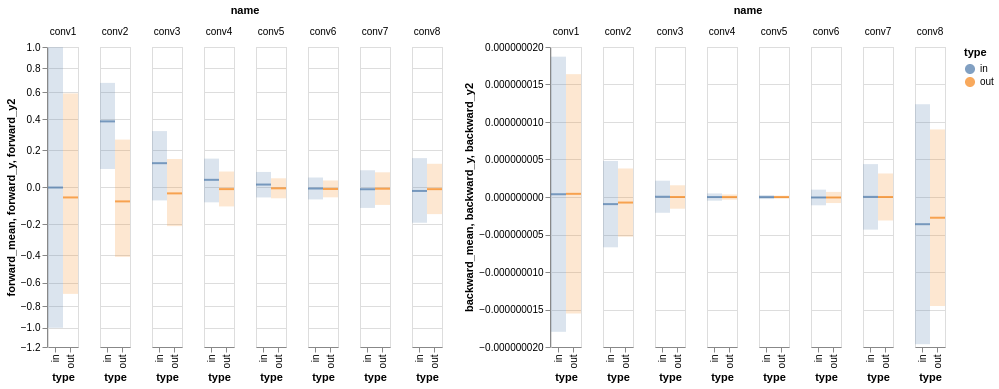

In [67]:
plot_variance(HemelingNet(1, 1, padding='same', batchnorm=False).cuda())

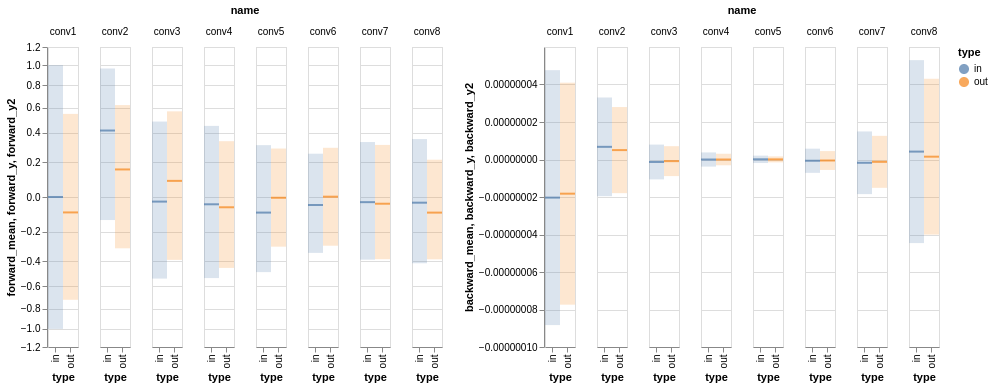

In [71]:
plot_variance(SteeredHemelingNet(1, 1, padding='same', batchnorm=False).cuda())